In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('Employee_Rentation.csv')
data.drop('Unnamed: 0', axis=1, inplace = True)

In [68]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [23]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [336]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
 7   quit_ind     24702 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 1.5+ MB


Clean up the extreme values in seniority; impute with average seriority of the company and department

In [343]:
data[data['seniority']>40]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_ind
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06,1


In [347]:
seniority_mean = data.groupby(['company_id','dept'])['seniority'].mean().reset_index()
seniority_mean.head()

,company_id,dept,seniority
0,1,customer_service,14.161229
1,1,data_science,14.502317
2,1,design,14.088176
3,1,engineer,13.926020
4,1,marketing,14.226728


In [351]:
seniority_mean[((seniority_mean['dept'] == 'engineer')&(seniority_mean['company_id'] == 10))| ((seniority_mean['dept'] == 'marketing')&(seniority_mean['company_id'] == 1))]

,company_id,dept,seniority
4,1,marketing,14.226728
57,10,engineer,14.732558


In [80]:
data.loc[24700,'seniority']= 15
data.loc[24701,'seniority']= 14

In [81]:
data.describe()

,employee_id,company_id,seniority,salary,quit_ind
count,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.121002,138183.345478,0.546919
std,288909.026101,2.700011,8.053813,76058.184573,0.497804
min,36.000000,1.000000,1.000000,17000.000000,0.000000
25%,250133.750000,1.000000,7.000000,79000.000000,0.000000
50%,500793.000000,2.000000,14.000000,123000.000000,1.000000
75%,753137.250000,5.000000,21.000000,187000.000000,1.000000
max,999969.000000,12.000000,29.000000,408000.000000,1.000000


# Create Table for Company Headcount by Day

### Step 1: create a table with only 2 columns, date and company_id. The number of rows should be total number of days times number of company id.

In [4]:
day_range = pd.date_range(start = '2011-01-24', end = '2015-12-13', freq = 'D')
day = pd.DataFrame(day_range.astype(str),columns=['date'])
day.shape

(1785, 1)

In [5]:
company_id=pd.DataFrame(data['company_id'].unique(),columns=['company_id'])

In [6]:
date_company=day.merge(company_id,how='cross').sort_values(by=['date','company_id']).reset_index()[['date','company_id']]
date_company.shape

(21420, 2)

### Step 2: Group the original table by comapny id and join date, and comapny id and quit date to get the total number of employees joining and quiting for each company on each date. Then join the two tables.

In [7]:
join_count=data.groupby(['company_id', 'join_date'])['employee_id'].count().reset_index()
join_count.rename(columns={'employee_id': 'count_join','join_date':'date'},inplace=True)
quit_count=data.groupby(['company_id', 'quit_date'])['employee_id'].count().reset_index()
quit_count.rename(columns={'employee_id': 'count_quit','quit_date':'date'},inplace=True)

In [8]:
join_quit_count = pd.merge(left=join_count,right=quit_count,on=['date','company_id'],how='outer',sort='date')
join_quit_count.head()

,company_id,date,count_join,count_quit
0,1,2011-01-24,25.0,NaN
1,2,2011-01-24,17.0,NaN
2,3,2011-01-24,9.0,NaN
3,4,2011-01-24,12.0,NaN
4,5,2011-01-24,5.0,NaN


### Step 3: Join the two tables from step 1 and 2 to get number of people joining and quitting for each company on each day. The number of rows for this final table should be the same as the number of rows from the table from step 1.

In [9]:
date_join_quit=pd.merge(left=date_company,right=join_quit_count,on=['date','company_id'],how='left')
date_join_quit.shape

(21420, 4)

In [10]:
date_join_quit.fillna(0,inplace=True)
date_join_quit.head()

,date,company_id,count_join,count_quit
0,2011-01-24,1,25.0,0.0
1,2011-01-24,2,17.0,0.0
2,2011-01-24,3,9.0,0.0
3,2011-01-24,4,12.0,0.0
4,2011-01-24,5,5.0,0.0


In [124]:
date_join_quit.shape

(21420, 4)

### Step 4: For each company, iterate over each day to get daily count.

Method 1: company_list within second for loop

In [11]:
company_list = []
total_count_list = []
date_list=[]

for company_id in date_join_quit['company_id'].unique().tolist():
    company_table = date_join_quit[date_join_quit['company_id']==company_id]

    daily_headcount = 0
    
    for day in company_table['date'].tolist():
        row = company_table[company_table['date'] == day]
        daily_headcount = daily_headcount + row['count_join'].tolist()[0] - row['count_quit'].tolist()[0]
        total_count_list.append(daily_headcount)
        date_list.append(day)
        company_list.append(company_id)

result=pd.DataFrame(data={'date':date_list,'company_id':company_list,'headcount':total_count_list})
    

In [12]:
result['date']=pd.to_datetime(result['date'])

In [13]:
# quick gut check to confirm total count is decreasing if there are people quiting
result[(result['date']>'2011-10-19') &  (result['date']<'2011-10-25') & (result['company_id']==1)]

,date,company_id,headcount
269,2011-10-20,1,1306.0
270,2011-10-21,1,1305.0
271,2011-10-22,1,1305.0
272,2011-10-23,1,1305.0
273,2011-10-24,1,1326.0


In [143]:
result.head()

,date,company_id,headcount
0,2011-01-24,1,25.0
1,2011-01-25,1,27.0
2,2011-01-26,1,29.0
3,2011-01-27,1,29.0
4,2011-01-28,1,29.0


Method 2: use list.extend()

In [14]:
company_list = []
total_count_list = []
date_list=[]

for company_id in date_join_quit['company_id'].unique().tolist():
    company_table = date_join_quit[date_join_quit['company_id']==company_id]

    daily_headcount = 0
    
    for day in company_table['date'].tolist():
        row = company_table[company_table['date'] == day]
        daily_headcount = daily_headcount + row['count_join'].tolist()[0] - row['count_quit'].tolist()[0]
        total_count_list.append(daily_headcount)
        date_list.append(day)
        
    company_list.extend([company_id] * len(company_table))

#     company_list.extend([company_id] * date_join_quit['date'].nunique()) ## this is not ideal in case # of days is not the same for each comapny
    
result2=pd.DataFrame(data={'date':date_list,'company_id':company_list,'headcount':total_count_list})
    

In [145]:
result2.head()

,date,company_id,headcount
0,2011-01-24,1,25.0
1,2011-01-25,1,27.0
2,2011-01-26,1,29.0
3,2011-01-27,1,29.0
4,2011-01-28,1,29.0


# Understand Main Factors That Drive Employee Churn

In [121]:
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

In [55]:
data['quit_ind']=data['quit_date'].apply(lambda x:0 if pd.isnull(x) else 1)

<Axes: xlabel='quit_ind', ylabel='count'>

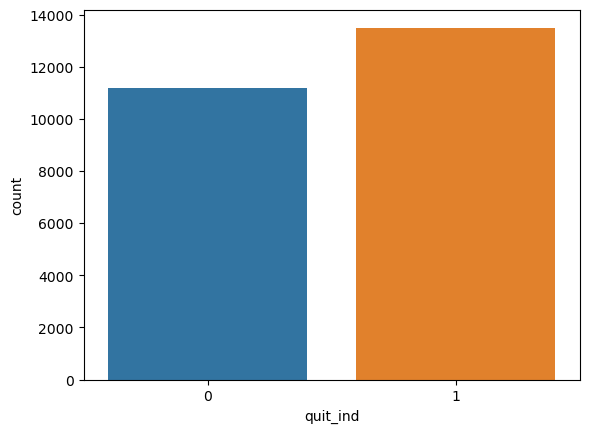

In [57]:
sns.countplot(data=data,x='quit_ind')

### Exploratory Analysis

#### Quit Month

In [124]:
data['quit_month']=data['quit_date'].apply(lambda x: x.month)

Text(0, 0.5, 'Frequency')

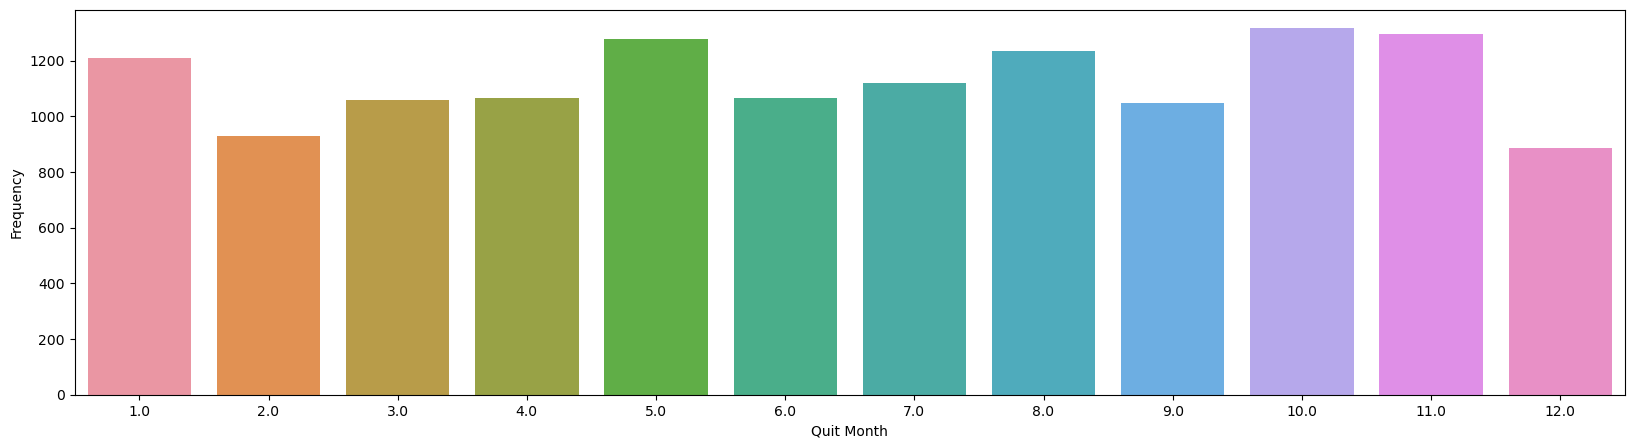

In [125]:
fig,ax=plt.subplots(figsize=[20,5])

sns.countplot(data=data, x='quit_month')

ax.set_xlabel('Quit Month')
ax.set_ylabel('Frequency')

There are some variability for the number of employees quitting each month. However, this data is not normalized so it does not provide much information. For example, there seems to be a greater number of people quiting in January, but maybe we have the highest number of employees joining in December. Therefore, it will be more useful to see the distribution of the share of employees quiting, out of the total number of employees employed at the time, by each month.

In [18]:
date_count=date_join_quit.groupby('date')[['count_join', 'count_quit']].sum().reset_index()
date_count['date']=pd.to_datetime(date_count['date'])
date_count['month']=date_count['date'].apply(lambda x:x.month)
date_count['year']=date_count['date'].apply(lambda x:x.year)

In [33]:
month_count=date_count.groupby(['year','month'])[['count_join','count_quit']].sum().reset_index()
month_count[['cumsum_join','cumsum_quit']]=month_count[['count_join','count_quit']].cumsum()
month_count['headcount']=month_count['cumsum_join']-month_count['cumsum_quit']
month_count['previous_month_headcount']=month_count['headcount'].shift(1)
month_count['share_quit']=month_count['count_quit']/month_count['previous_month_headcount']
month_count.head()

,year,month,count_join,count_quit,cumsum_join,cumsum_quit,headcount,previous_month_headcount,share_quit
0,2011,1,175.0,0.0,175.0,0.0,175.0,NaN,NaN
1,2011,2,360.0,0.0,535.0,0.0,535.0,175.0,0.0
2,2011,3,386.0,0.0,921.0,0.0,921.0,535.0,0.0
3,2011,4,378.0,0.0,1299.0,0.0,1299.0,921.0,0.0
4,2011,5,468.0,0.0,1767.0,0.0,1767.0,1299.0,0.0


Text(0.5, 1.0, 'probability of quitting')

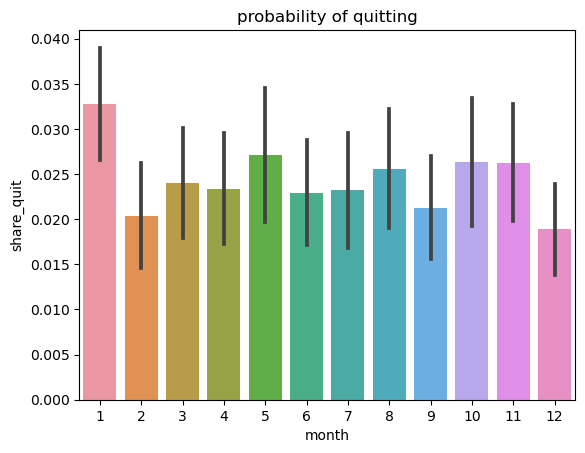

In [32]:
sns.barplot(data=month_count,x='month',y='share_quit',estimator='mean', errorbar=('se')).set_title('probability of quitting')

From this graph above, we can see that the probability of employees (estimated probability is 3.3%) quiting in January is way higher than other months. Employees are the least likely to quit in December, with a around 2% probability.

#### Number of Days At the Company

In [116]:
data['days_worked']=data['quit_date']-data['join_date']
data['days_worked'] = data['days_worked'].dt.days
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_ind,days_worked
0,13021.0,7,customer_service,28.0,89000.0,2014-03-24,2015-10-30,1,585.0
1,825355.0,7,marketing,20.0,183000.0,2013-04-29,2014-04-04,1,340.0
2,927315.0,4,marketing,14.0,101000.0,2014-10-13,NaT,0,NaN
3,662910.0,7,customer_service,20.0,115000.0,2012-05-14,2013-06-07,1,389.0
4,256971.0,2,data_science,23.0,276000.0,2011-10-17,2014-08-22,1,1040.0


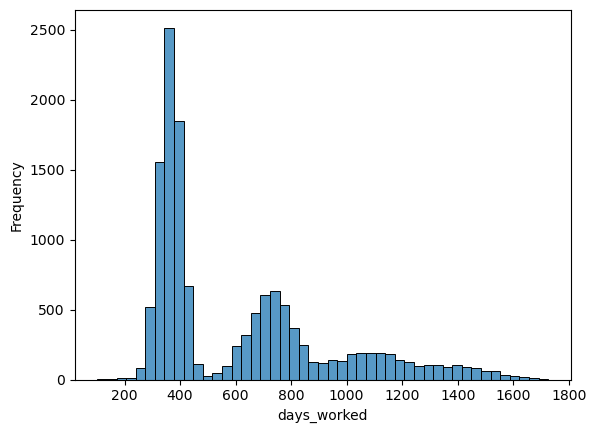

In [117]:
ax = sns.histplot(data=data,x='days_worked')
ax.set_ylabel('Frequency')
plt.show()

There a peak of quitting around 1 year anniversay. Then there's another smaller spike around 2-year anniversary. 

#### Seniority and Salary

Text(0, 0.5, 'share_quit')

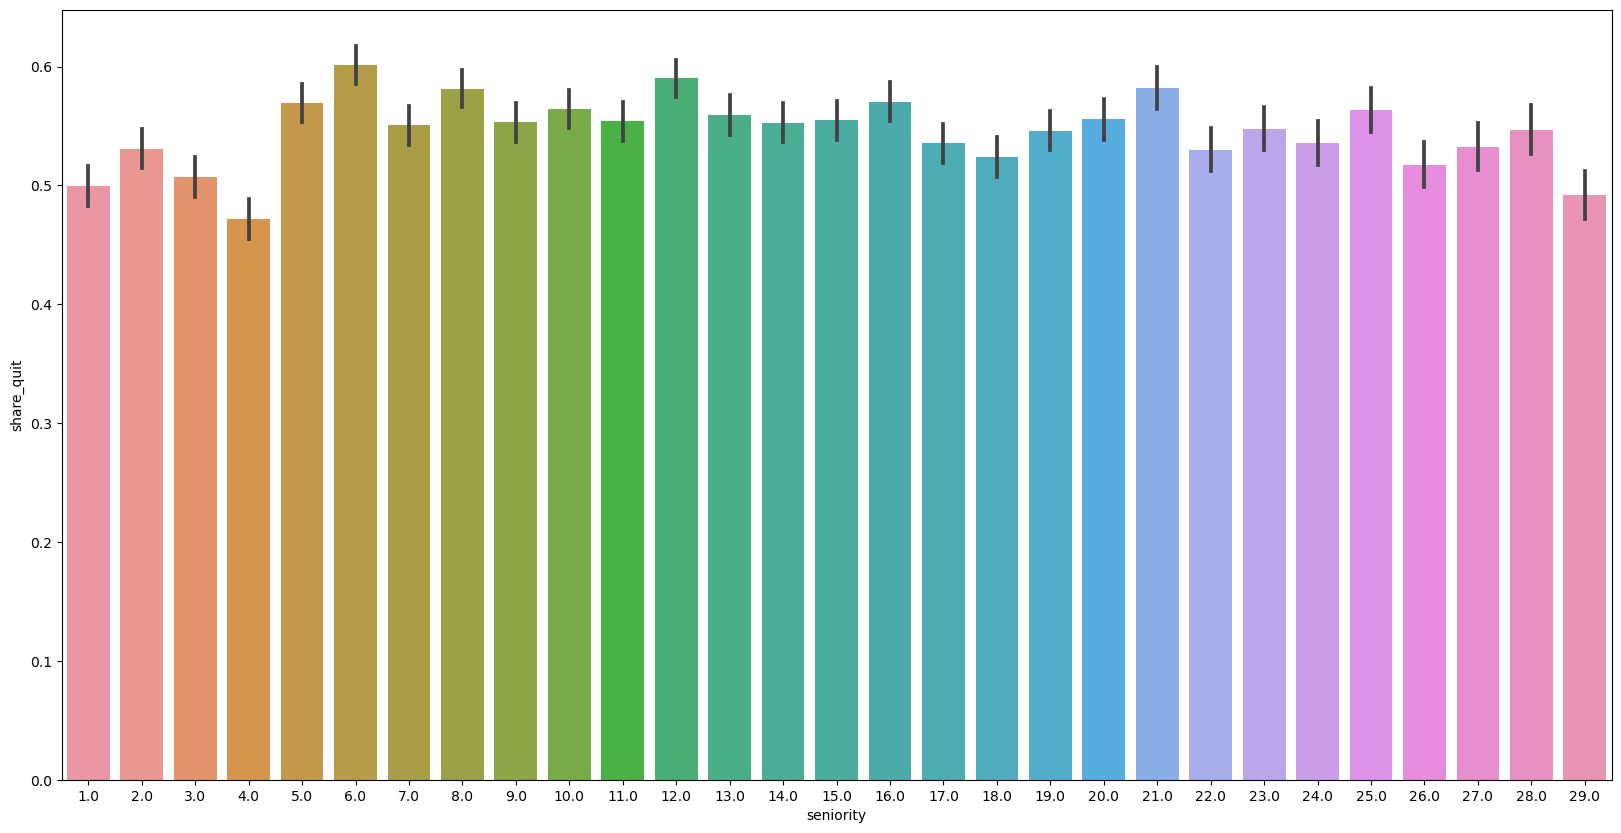

In [104]:
plt.figure(figsize=[20,10])
sns.barplot(data=data, x='seniority',y='quit_ind',estimator='mean',errorbar=('se')).set_ylabel('share_quit')

Comparatively, people with less than 4 years working experience are less likely to quit.

<Axes: xlabel='salary', ylabel='Count'>

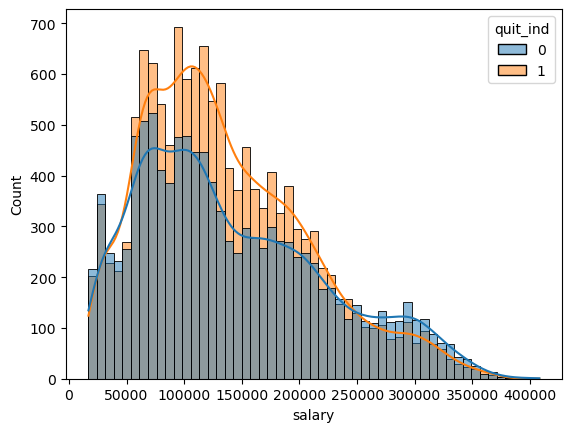

In [103]:
sns.histplot(data=data,x='salary',hue='quit_ind',kde=True)

Comparative, people who makes between 70,000 and 230,000 are more likely to quit.

#### Department and Company

Text(0, 0.5, 'share_quit')

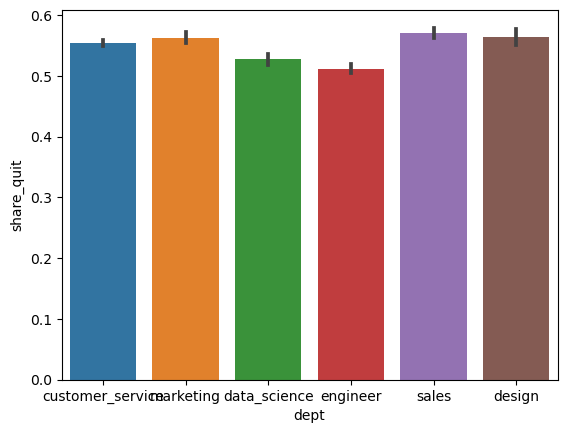

In [108]:
sns.barplot(data=data, x='dept',y='quit_ind',estimator='mean',errorbar=('se')).set_ylabel('share_quit')

Text(0, 0.5, 'share_quit')

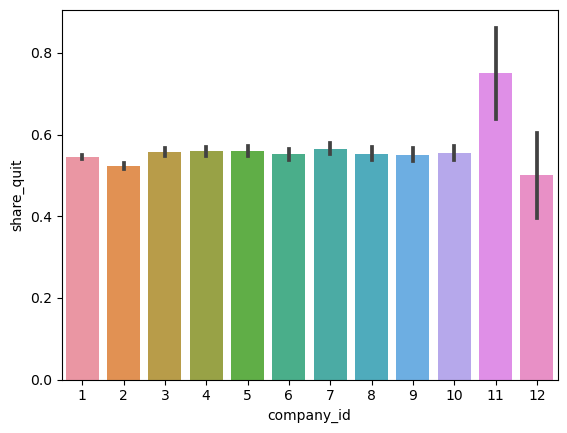

In [109]:
sns.barplot(data=data, x='company_id',y='quit_ind',estimator='mean',errorbar=('se')).set_ylabel('share_quit')

## Summary of EDA
To quickly summarize findings from what we've done so far:
1. Churn rate is the highest in January, and the lowest in December. This makes sense intuitively as December is a holiday season and hiring activies might be slow. A lot of companies also have year end reviews which may cause some employees to leave in the new year.
2. There a peak of churning around 1 year anniversay. Then there's another smaller spike around 2-year anniversary. 
3. Churn rate for people with less than 4 years working experience are lower than those with more experience.
4. Churn rate for people who makes between 70,000 and 230,000 are significantly higher than those who make less or more than this range.
5. Data science and engineering departments have lower churn rates than all other departments.
6. Company 11 has a higher churn rate and all other companies.
7. Company 12 has an average churn rate lower than all other companies, though its churn rate is a lot more volatile than other companies.

# Build a Tree Model

In [148]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_ind,days_worked,quit_month
0,13021.0,7,customer_service,28.0,89000.0,2014-03-24,2015-10-30,1,585.0,10.0
1,825355.0,7,marketing,20.0,183000.0,2013-04-29,2014-04-04,1,340.0,4.0
2,927315.0,4,marketing,14.0,101000.0,2014-10-13,NaT,0,NaN,NaN
3,662910.0,7,customer_service,20.0,115000.0,2012-05-14,2013-06-07,1,389.0,6.0
4,256971.0,2,data_science,23.0,276000.0,2011-10-17,2014-08-22,1,1040.0,8.0


In [150]:
from sklearn.preprocessing import LabelEncoder

In [183]:
X=data[['company_id','seniority','salary']]
y=data[['quit_ind']]

In [154]:
# le = LabelEncoder()
# X['dept'] = le.fit_transform(data['dept'])

/var/folders/_g/5wq80nr13wv9wfwcz5y8sscw0000gp/T/ipykernel_3222/4232258636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dept'] = le.fit_transform(data['dept'])


In [ ]:
from sklearn.model_selection import train_test_split

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [185]:
dtree = DecisionTreeClassifier()

In [186]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [187]:
predictions = dtree.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [188]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.46      0.52      0.49      3337
           1       0.56      0.50      0.53      4074

    accuracy                           0.51      7411
   macro avg       0.51      0.51      0.51      7411
weighted avg       0.51      0.51      0.51      7411



In [189]:
print(confusion_matrix(y_test,predictions))

[[1736 1601]
 [2045 2029]]


The tree model has an accuracy of 0.51 which is higher than random guessing.

In [173]:
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydot 

In [190]:
features = list(X.columns)
features

['company_id', 'seniority', 'salary']

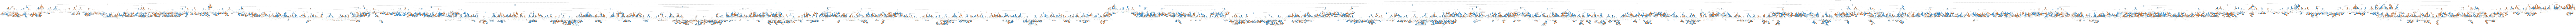

In [191]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

# Next Steps
If there's additional time and resources, we should look into the following:
- Get more data on Company 11 and 12 to see what is causing the high/low churn rates, and what is causing the high vaolatility for Company 12.
- Of people who makes between 70,000 and 230,000, what else would make them more likely to churn? Perhaps those have stayed in the same company for very long but did not get any salary improvement over the years. Or maybe because competitors at other companies are more likely to provide higher compensation.
- Additional data points that may be useful are: compensations of employee's next job offer when they quit, age of the employee, whether the employee has had a promotion at the company, average working hours per week